In [1]:
import tensorflow as tf
if tf.__version__[0]=='2':
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
print('available accelerator:',tf.test.gpu_device_name())

Instructions for updating:
non-resource variables are not supported in the long term
available accelerator: /device:GPU:0


In [2]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import * 
from tensorflow.keras.losses import binary_crossentropy
from sklearn.utils import shuffle
import scipy
from shutil import *
from tensorflow.keras.utils import Sequence 
from glob import glob
import albumentations as albu
import segmentation_models
import random
#from segmentation_models import Unet,Linknet,PSPNet
from model import build_model
from segmentation_models.losses import *
from segmentation_models.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

Segmentation Models: using `keras` framework.
1.0.1


Using TensorFlow backend.


In [25]:
img_fnames=sorted(glob('images/*/*'))
mask_fnames=sorted(glob('masks/*/*'))
test_fnames=sorted(glob('test/images/*'))
img_fnames[0],mask_fnames[0],test_fnames[0]

('images/000924cf-0f8d-42bd-9158-1af53881a557/image.png',
 'masks/000924cf-0f8d-42bd-9158-1af53881a557/Label_765.png',
 'test/images/0.jpeg')

In [4]:
#globals 
n_classes=1
redux=1.0
size=(256,256,3)
width=size[0]
height=size[1]
channels=size[2]
batch_size=4
seed=23
set_=int(input('Enter the set:'))
np.random.seed(seed)
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
pos_thresh=512
#7317 526

Enter the set:0


In [5]:
split_fnames=kf.split(img_fnames,mask_fnames)
print('Num splits:',kf.get_n_splits(img_fnames,mask_fnames))

split_train_img=[]
split_train_mask=[]

split_val_img=[]
split_val_mask=[]
count=0

for train_id,val_id in (split_fnames):
  
  if count==set_:
    x=train_id
    y=val_id
  count+=1

print('total train_val data split for current set:',len(x),len(y))


for i in x:

  if plt.imread(mask_fnames[i]).sum()>pos_thresh:
    #print(plt.imread(mask_fnames[i]).sum())
    split_train_img.append(img_fnames[i])
    split_train_mask.append(mask_fnames[i])
    #print(a,b)
    #break


for i in y:

  if plt.imread(mask_fnames[i]).sum()>pos_thresh:
    #print(plt.imread(mask_fnames[i]).sum())
    split_val_img.append(img_fnames[i])
    split_val_mask.append(mask_fnames[i])
    #print(a,b)
    #break


print('total train_val data split for current set:',len(split_train_img),len(split_train_mask),len(split_val_img),len(split_val_mask))


Num splits: 5
total train_val data split for current set: 800 200
total train_val data split for current set: 794 794 200 200


In [6]:
class datagen(Sequence):
  def __init__(self,train_im_path,train_mask_path,augmentations,batch_size,img_size=256,nchannels=3,normalize_img=False,shuffle=True):
    self.batch_size=batch_size
    self.train_im_paths=train_im_path
    self.train_mask_paths=train_mask_path
    self.img_size=img_size
    self.nchannels=nchannels
    self.shuffle=shuffle
    ## maps bw 0-1
    self.normalize_img=normalize_img
    self.augmentations=augmentations
    self.on_epoch_end()
    print('Num images found : {}'.format(len(self.train_im_paths)))
    print('Num masks found : {}'.format(len(self.train_im_paths)))
  def __len__(self):
    return int(np.ceil(len(self.train_im_paths) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

    list_IDs_im = [self.train_im_paths[k] for k in indexes]
    list_IDs_mask = [self.train_mask_paths[k] for k in indexes]
    
    X= self.data_generation(list_IDs_im,'rgb')
    y= self.data_generation(list_IDs_mask,'grayscale')
    if not(X.shape==(X.shape[0],self.img_size,self.img_size,3)):
      print(X.shape)
    if not(y.shape==(y.shape[0],self.img_size,self.img_size,1)):
      print(y.shape)
    if self.augmentations==None:
      if self.normalize_img:
        return self.normalize(X),self.scaler(y)
      return X,self.scaler(y)
    else:
      im,mask = [],[]
      for x,y in zip(X,y):
        augmented = self.augmentations(image=x, mask=y)
        im.append(augmented['image'])
        mask.append(augmented['mask'])
      if self.normalize_img:
        return self.normalize(im),self.scaler(np.array(mask))
      else:
        return np.array(im),self.scaler(np.array(mask))
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.train_im_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  def data_generation(self,list_IDs,color_mode):
    if color_mode=='rgb':
      X = np.empty((len(list_IDs),self.img_size,self.img_size, 3))

    if color_mode=='grayscale':
      X = np.empty((len(list_IDs),self.img_size,self.img_size, 1))

    for count,i in enumerate(list_IDs):
      x=img_to_array(load_img(path=i,target_size=(self.img_size,self.img_size),color_mode=color_mode))
      if color_mode=='rgb':
        x=np.expand_dims(x,axis=0)
      if color_mode=='grayscale':
        x=np.expand_dims(x,axis=0)

      X[count]=x
    return np.uint8(X)
  
  def scaler(self,x):
    x[x>0]=1
    return x
  
  def normalize(self,x):
    return np.array(x,dtype=np.float32)/255.0


In [47]:
'''AUGMENTATIONS_TRAIN= albu.Compose([
        albu.HorizontalFlip(p=0.5)
    ], p=1.0)'''
    
AUGMENTATIONS_TRAIN= albu.Compose([
        albu.Flip(),
        albu.RandomBrightnessContrast(),            
        albu.OneOf([
            albu.IAAAdditiveGaussianNoise(),
            albu.GaussNoise(),
        ], p=0.5),
        albu.OneOf([
            albu.MotionBlur(p=.2),
            albu.MedianBlur(blur_limit=3, p=0.1),
            albu.Blur(blur_limit=3, p=0.1),
        ], p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.0001, scale_limit=0.001, rotate_limit=45),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
            albu.ElasticTransform(p=0.3)
        ], p=0.5),

    ], p=1.0)

In [48]:
gen=datagen(split_train_img,split_train_mask,None,batch_size,width,channels,shuffle=False)
valgen=datagen(split_val_img,split_val_mask,None,batch_size,width,channels,shuffle=False)
aug_gen=datagen(split_train_img,split_train_mask,AUGMENTATIONS_TRAIN,batch_size,width,channels,shuffle=False)
testgen=datagen(test_fnames,test_fnames,None,len(test_fnames),width,channels,shuffle=False)

Num images found : 794
Num masks found : 794
Num images found : 200
Num masks found : 200
Num images found : 794
Num masks found : 794
Num images found : 60
Num masks found : 60


index: 90
uint8 uint8
(4, 256, 256, 3) (4, 256, 256, 1)
uint8 uint8
(4, 256, 256, 3) (4, 256, 256, 1)


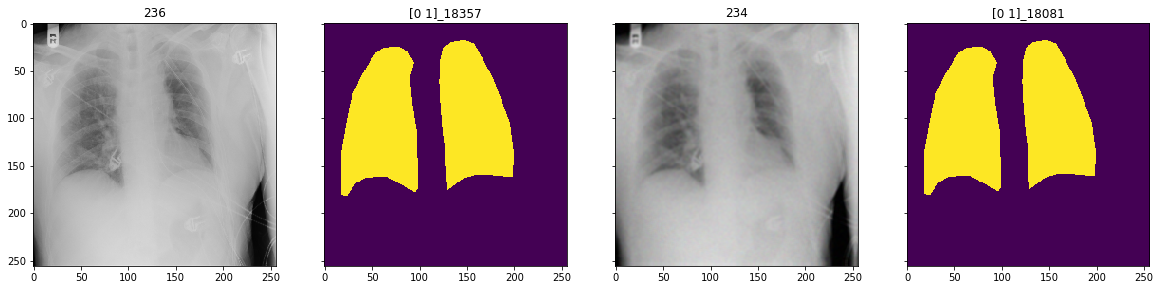

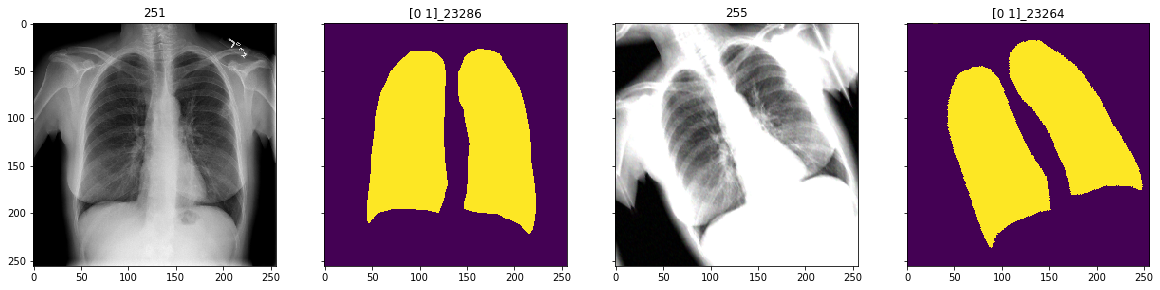

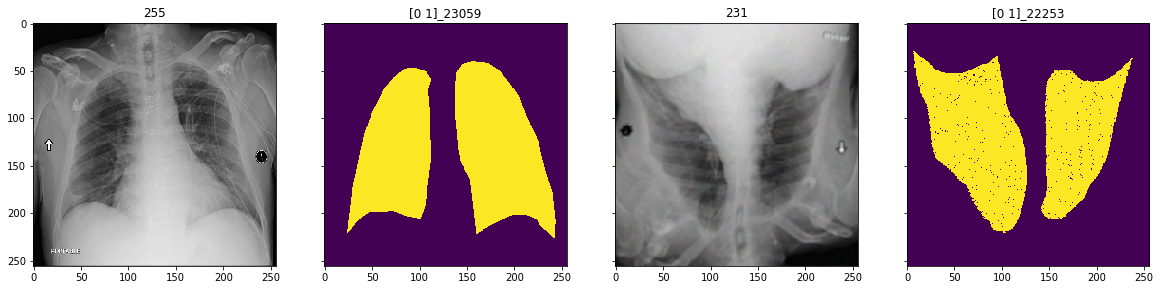

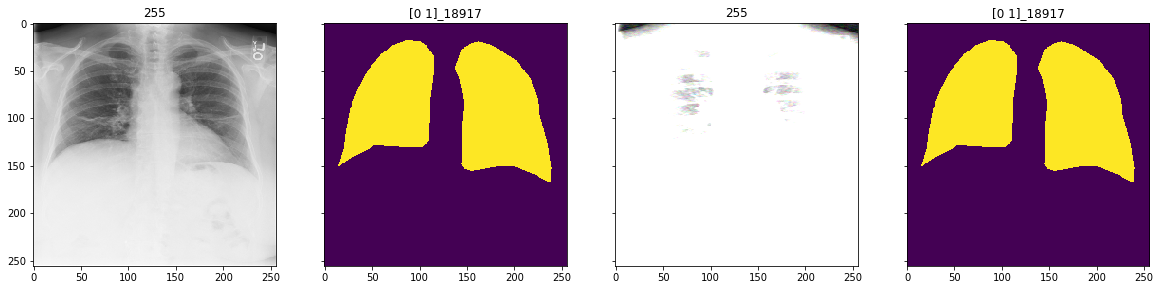

In [49]:
id=np.random.randint(0,len(gen))
print('index:',id)
img,mask=gen[id]
print(img.dtype,mask.dtype)
print(img.shape,mask.shape)
augimg,augmask=aug_gen[id]
print(augimg.dtype,augmask.dtype)
print(augimg.shape,augmask.shape)
for i in range(augimg.shape[0]):
  fig,ax=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(20,20))
  ax[0].title.set_text(str(np.max(img[i])))
  ax[0].imshow(img[i])
  ax[1].title.set_text(str(np.unique(mask[i]))+'_'+str(mask[i].sum()))
  ax[1].imshow(np.squeeze(mask[i]).astype(np.float32))
  ax[2].title.set_text(str(np.max(augimg[i])))
  ax[2].imshow(augimg[i])
  ax[3].title.set_text(str(np.unique(augmask[i]))+'_'+str(augmask[i].sum()))
  ax[3].imshow(np.squeeze(augmask[i]).astype(np.float32))
  plt.show()

index: 25


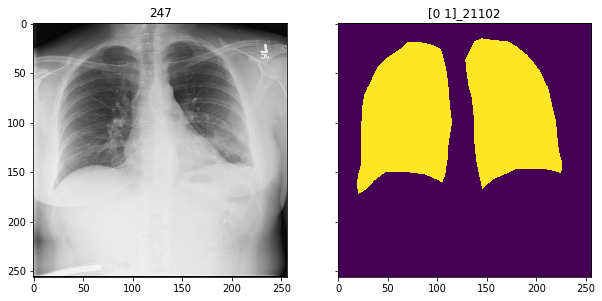

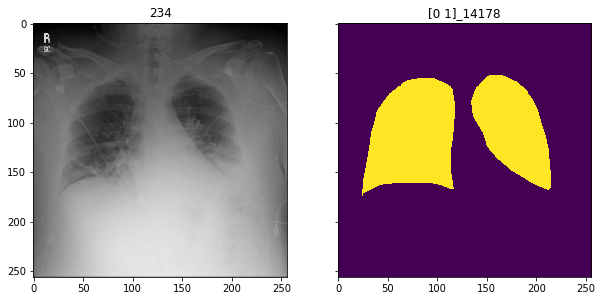

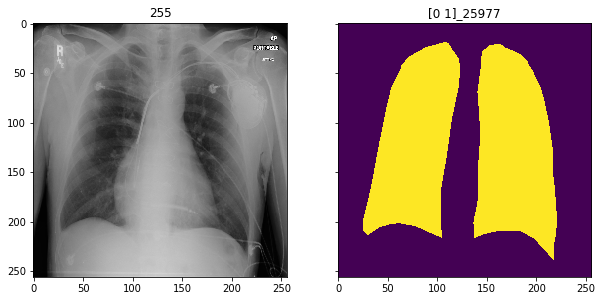

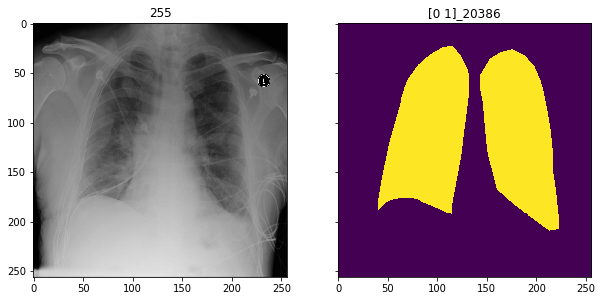

In [50]:
id=np.random.randint(0,len(valgen))
print('index:',id)
img,mask=valgen[id]

for i in range(img.shape[0]):
  fig,ax=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(10,10))
  ax[0].title.set_text(str(np.max(img[i])))
  ax[0].imshow(img[i])
  ax[1].title.set_text(str(np.unique(mask[i]))+'_'+str(mask[i].sum()))
  ax[1].imshow(np.squeeze(mask[i]).astype(np.float32))


In [56]:
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)
model=build_model(image_size=size,
                    redux=redux,
                  show_flops=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 128, 128, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           bn1[0][0]                        
______________________________________________________________________________________________

In [52]:
dice_loss = DiceLoss()
per_img_dice_loss=DiceLoss(per_image=True)
bf_loss = BinaryFocalLoss()
iou=IOUScore(per_image=True)
bce=binary_crossentropy
total_loss = bce_dice_loss
jac_loss=jaccard_loss

In [57]:
model.compile(optimizer='adam', loss=total_loss,metrics=[iou])
print('tf version:',tf.__version__)
print('init_lr:',K.eval(model.optimizer.lr))

tf version: 2.1.0
init_lr: 0.001


In [37]:
K.set_value(model.optimizer.lr,5e-4)

In [59]:
initial_epoch=83
train_count=len(split_train_img)
val_count=len(split_val_img)
final_epoch=200
callbacks=None
print('tf version:',tf.__version__)
print('available accelerator:',tf.test.gpu_device_name())
print('init_lr:',K.eval(model.optimizer.lr))
print ('callbacks:',callbacks)
print('loss:',model.loss)
print ('train:{} val:{} bs:{} lr:{} opt:{}'.format(train_count,val_count,batch_size,K.eval(model.optimizer.lr),model.optimizer))
history = model.fit_generator(
      aug_gen,
      steps_per_epoch=(train_count/batch_size)*1,
      validation_data=valgen,
      validation_steps=(val_count/batch_size),
      epochs=final_epoch,
      verbose=1,callbacks=callbacks,initial_epoch=initial_epoch)
#0.88 0.25

tf version: 2.1.0
available accelerator: /device:GPU:0
init_lr: 0.001
callbacks: None
loss: <segmentation_models.base.objects.SumOfLosses object at 0x7ff1ff7316a0>
train:794 val:200 bs:4 lr:0.0010000000474974513 opt:<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fef2407cdd8>
Epoch 84/200
199/198 [==============================] - 36s 179ms/step - loss: 0.2484 - iou_score: 0.8055 - val_loss: 0.1497 - val_iou_score: 0.8689
Epoch 85/200
199/198 [==============================] - 32s 161ms/step - loss: 0.2534 - iou_score: 0.8031 - val_loss: 0.1478 - val_iou_score: 0.8734
Epoch 86/200
199/198 [==============================] - 32s 162ms/step - loss: 0.2666 - iou_score: 0.7926 - val_loss: 0.1618 - val_iou_score: 0.8721
Epoch 87/200
199/198 [==============================] - 34s 169ms/step - loss: 0.2524 - iou_score: 0.7997 - val_loss: 0.1552 - val_iou_score: 0.8702
Epoch 88/200
199/198 [==============================] - 33s 164ms/step - loss: 0.2637 - iou_score: 0.7944 - val_lo

199/198 [==============================] - 29s 148ms/step - loss: 0.2261 - iou_score: 0.8193 - val_loss: 0.1410 - val_iou_score: 0.8796
Epoch 150/200
199/198 [==============================] - 31s 158ms/step - loss: 0.2320 - iou_score: 0.8149 - val_loss: 0.1474 - val_iou_score: 0.8726
Epoch 151/200
199/198 [==============================] - 33s 167ms/step - loss: 0.2410 - iou_score: 0.8102 - val_loss: 0.1450 - val_iou_score: 0.8758
Epoch 152/200
199/198 [==============================] - 33s 164ms/step - loss: 0.2430 - iou_score: 0.8096 - val_loss: 0.1448 - val_iou_score: 0.8757
Epoch 153/200
199/198 [==============================] - 33s 164ms/step - loss: 0.2427 - iou_score: 0.8099 - val_loss: 0.1398 - val_iou_score: 0.8800
Epoch 154/200
199/198 [==============================] - 30s 150ms/step - loss: 0.2312 - iou_score: 0.8167 - val_loss: 0.1412 - val_iou_score: 0.8821
Epoch 155/200
199/198 [==============================] - 32s 160ms/step - loss: 0.2375 - iou_score: 0.8134 - val_l

KeyboardInterrupt: 

index: 0


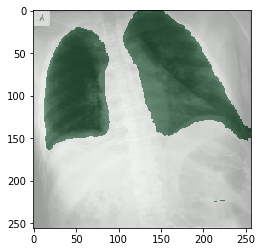

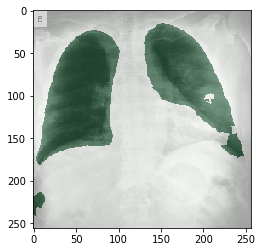

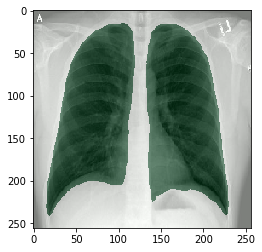

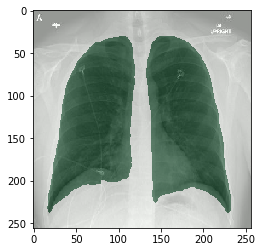

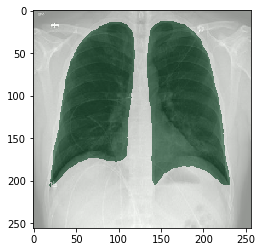

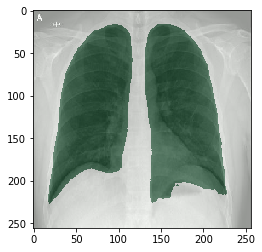

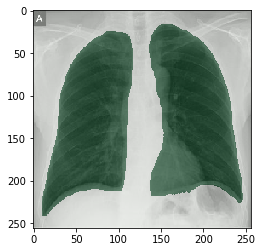

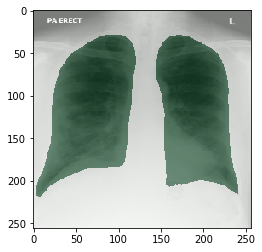

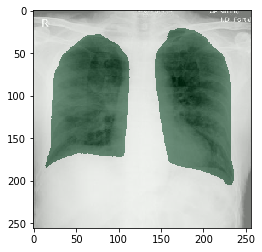

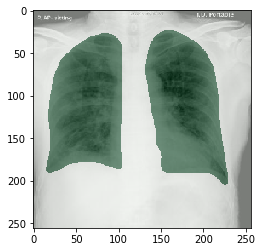

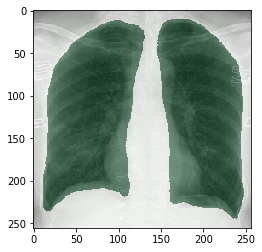

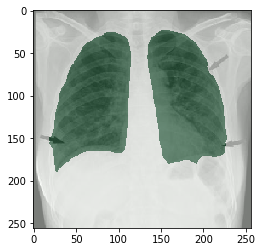

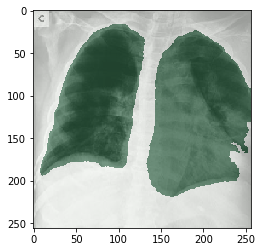

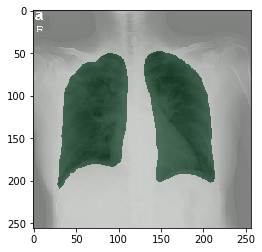

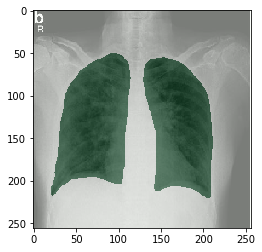

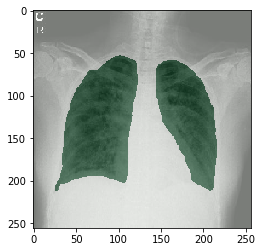

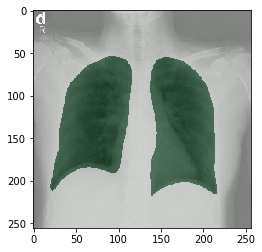

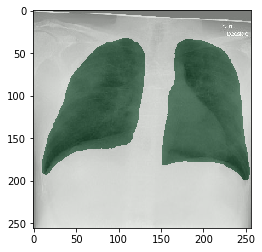

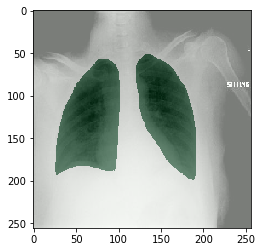

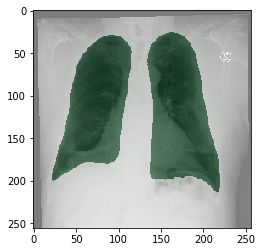

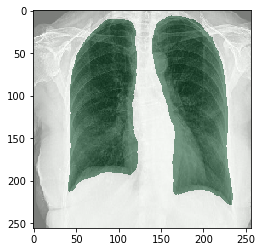

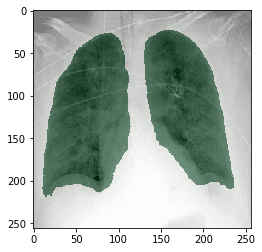

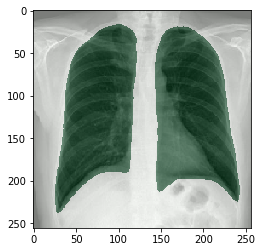

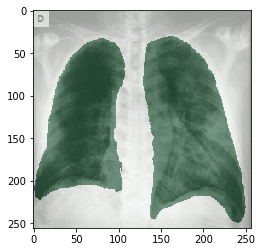

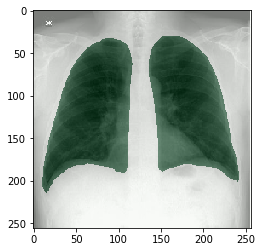

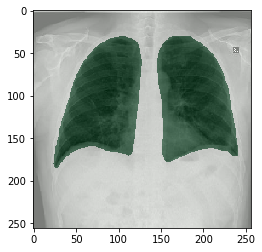

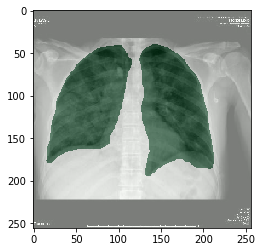

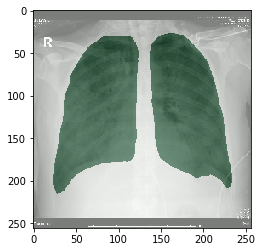

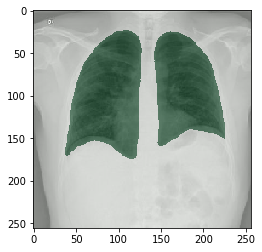

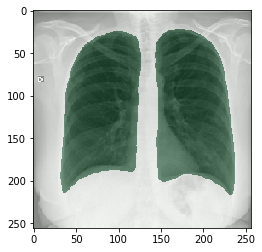

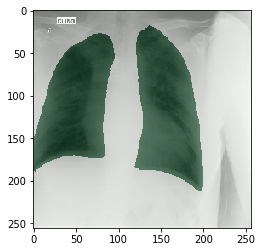

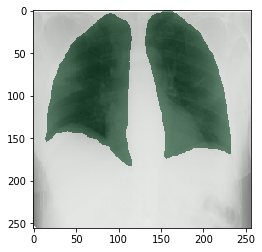

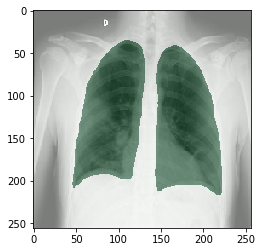

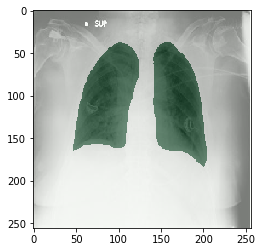

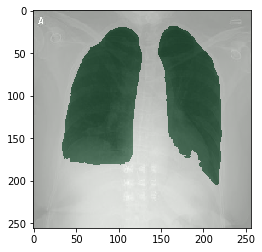

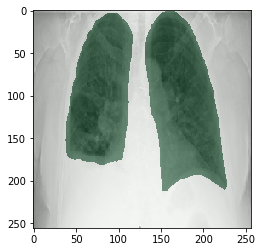

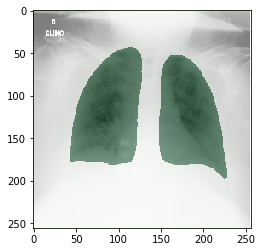

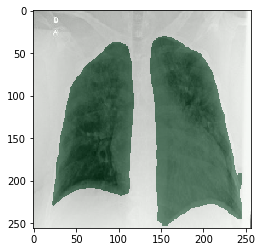

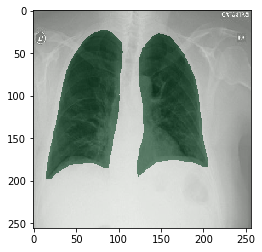

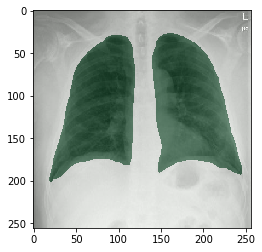

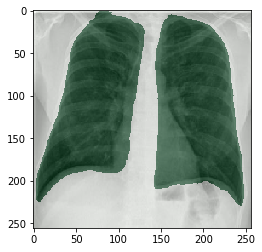

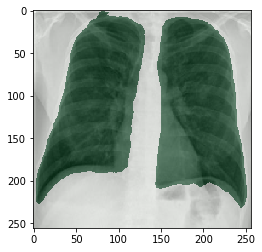

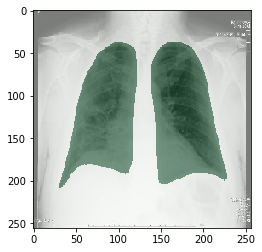

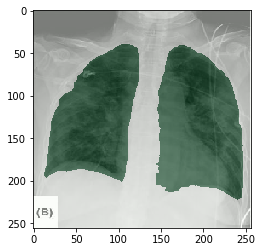

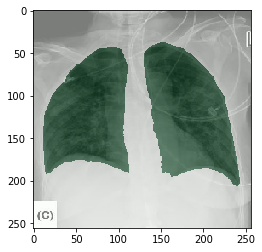

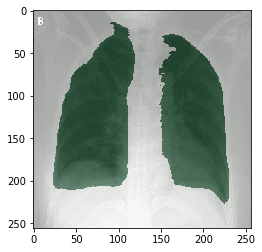

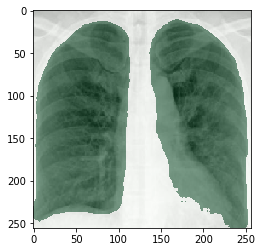

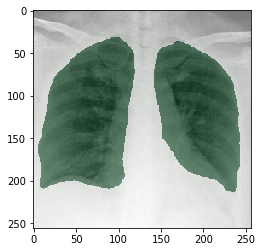

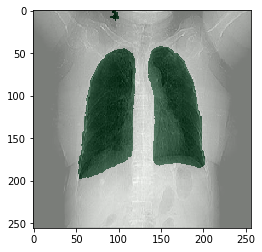

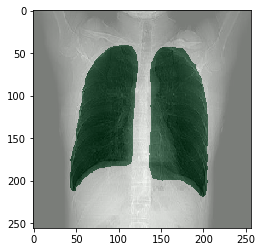

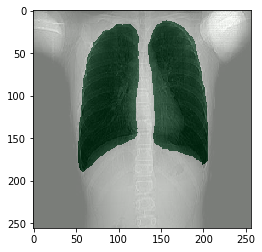

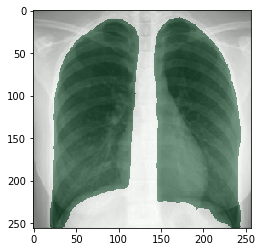

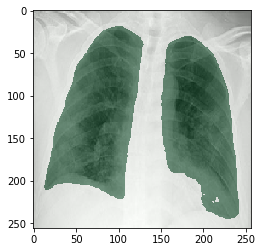

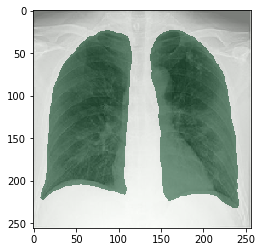

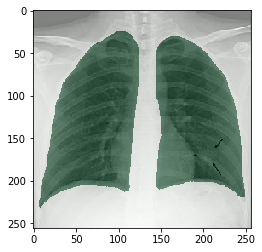

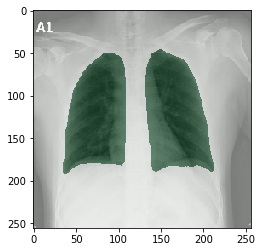

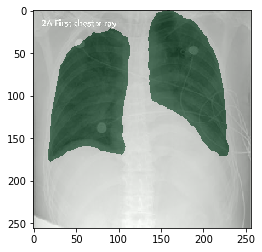

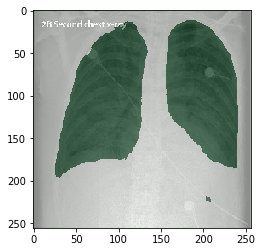

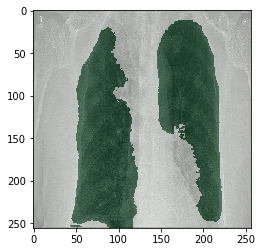

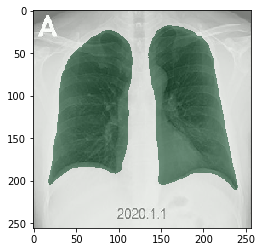

In [35]:
# View a test image
id=np.random.randint(0,len(testgen))
print('index:',id)
img,_=testgen[id]

for i in range(img.shape[0]):
    pred_mask=model.predict(np.expand_dims(img[i],axis=0))
    pred_mask[pred_mask>0.5]=1.0
    pred_mask[pred_mask<0.5]=0.0
    plt.imshow(img[i])
    plt.imshow(np.squeeze(pred_mask),alpha=0.5,cmap='Greens')
    plt.show()

In [31]:
model.save('lung_seg_valiou_088.h5',include_optimizer=False)